In [31]:
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [32]:
# Based on the work done by Wes McKinney based on the blog post linked below.
# https://wesmckinney.com/blog/python-parquet-update/

<IPython.core.display.Javascript object>

In [33]:
import os
import glob
import time
from datetime import datetime

import fastparquet as fp
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import plotly.express as px
from tqdm.notebook import tqdm

<IPython.core.display.Javascript object>

In [34]:
def generate_floats(n, pct_null, repeats=1):
    n_unique = int(n / repeats)
    unique_values = np.random.randn(n_unique)

    num_nulls = int(n_unique * pct_null)
    null_indices = np.random.choice(n_unique, size=num_nulls, replace=False)
    unique_values[null_indices] = np.nan

    return unique_values.repeat(repeats)

<IPython.core.display.Javascript object>

In [35]:
DATA_GENERATORS = {"float64": generate_floats}

<IPython.core.display.Javascript object>

In [36]:
def generate_data(total_size, ncols, pct_null=0.1, repeats=1, dtype="float64"):
    type_ = np.dtype("float64")
    nrows = total_size / ncols / np.dtype(type_).itemsize

    datagen_func = DATA_GENERATORS[dtype]

    data = {"c" + str(i): datagen_func(nrows, pct_null, repeats) for i in range(ncols)}
    return pd.DataFrame(data)

<IPython.core.display.Javascript object>

In [37]:
def write_to_parquet(df, out_path, compression="SNAPPY"):
    arrow_table = pa.Table.from_pandas(df)
    if compression == "UNCOMPRESSED":
        compression = None
    pq.write_table(arrow_table, out_path, use_dictionary=False, compression=compression)

<IPython.core.display.Javascript object>

In [38]:
def read_fastparquet(path):
    return fp.ParquetFile(path).to_pandas()

<IPython.core.display.Javascript object>

In [39]:
def read_pyarrow(path):
    return pq.read_table(path).to_pandas()

<IPython.core.display.Javascript object>

In [40]:
def write_fastparquet(df, out_path, compression):
    if compression == "UNCOMPRESSED":
        compression = None
    fp.write(out_path, df, compression=compression)

<IPython.core.display.Javascript object>

In [41]:
def write_pyarrow(df, out_path, compression):
    arrow_table = pa.Table.from_pandas(df)
    if compression == "UNCOMPRESSED":
        compression = None
    pq.write_table(arrow_table, out_path, use_dictionary=False, compression=compression)

<IPython.core.display.Javascript object>

In [42]:
MEGABYTE = 1 << 20
DATA_SIZE = 512 * MEGABYTE
NCOLS = 16

<IPython.core.display.Javascript object>

In [43]:
cases = {
    "high_entropy": {"pct_null": 0.1, "repeats": 1},
    "low_entropy": {"pct_null": 0.1, "repeats": 1000},
}

<IPython.core.display.Javascript object>

In [44]:
COMPRESSIONS = ["UNCOMPRESSED", "SNAPPY", "GZIP"]

<IPython.core.display.Javascript object>

In [45]:
def get_timing_read(f, path, niter):
    start = time.clock_gettime(time.CLOCK_MONOTONIC)
    for i in range(niter):
        f(path)
    elapsed = time.clock_gettime(time.CLOCK_MONOTONIC) - start
    return elapsed

<IPython.core.display.Javascript object>

In [46]:
def get_timing_write(f, path, df, compression, niter):
    start = time.clock_gettime(time.CLOCK_MONOTONIC)
    for i in range(niter):
        f(df, path, compression)
    elapsed = time.clock_gettime(time.CLOCK_MONOTONIC) - start
    return elapsed

<IPython.core.display.Javascript object>

In [47]:
NITER = 50

<IPython.core.display.Javascript object>

In [48]:
writers = [
    (
        "fastparquet",
        lambda df, path, compression: write_fastparquet(df, path, compression),
    ),
    ("pyarrow", lambda df, path, compression: write_pyarrow(df, path, compression)),
]

<IPython.core.display.Javascript object>

In [49]:
write_results = []

for case, params in tqdm(cases.items(), "Cases"):
    df = generate_data(DATA_SIZE, NCOLS, **params)
    for compression in tqdm(COMPRESSIONS, desc="Compression"):
        for writer_name, f in tqdm(writers, desc="Writers"):
            path = "{}_{}_{}.parquet".format(case, compression, writer_name)
            elapsed = get_timing_write(f, path, df, compression, NITER)
            result = case, compression, writer_name, elapsed
            write_results.append(result)

<IPython.core.display.Javascript object>

In [50]:
case_files = {}

for case, params in tqdm(cases.items(), "Cases"):
    for compression in tqdm(COMPRESSIONS, desc="Compression"):
        path = "{0}_{1}.parquet".format(case, compression)
        df = generate_data(DATA_SIZE, NCOLS, **params)
        write_to_parquet(df, path, compression=compression)
        df = None
        case_files[case, compression] = path

<IPython.core.display.Javascript object>

In [51]:
readers = [
    ("fastparquet", lambda path: read_fastparquet(path)),
    ("pyarrow", lambda path: read_pyarrow(path)),
]

<IPython.core.display.Javascript object>

In [52]:
read_results = []

for case, params in tqdm(cases.items(), "Cases"):
    for compression in tqdm(COMPRESSIONS, desc="Compression"):
        path = case_files[case, compression]

        # prime the file cache
        read_pyarrow(path)
        read_pyarrow(path)

        for reader_name, f in tqdm(readers, desc="Readers"):
            elapsed = get_timing_read(f, path, NITER) / NITER
            result = case, compression, reader_name, elapsed
            read_results.append(result)

<IPython.core.display.Javascript object>

In [53]:
# Clean up parquet files generated by the notebook.
for file in glob.glob("./*.parquet"):
    os.remove(file)

<IPython.core.display.Javascript object>

In [54]:
read_df = pd.DataFrame(
    read_results, columns=["entropy", "compression", "library", "duration"]
)

<IPython.core.display.Javascript object>

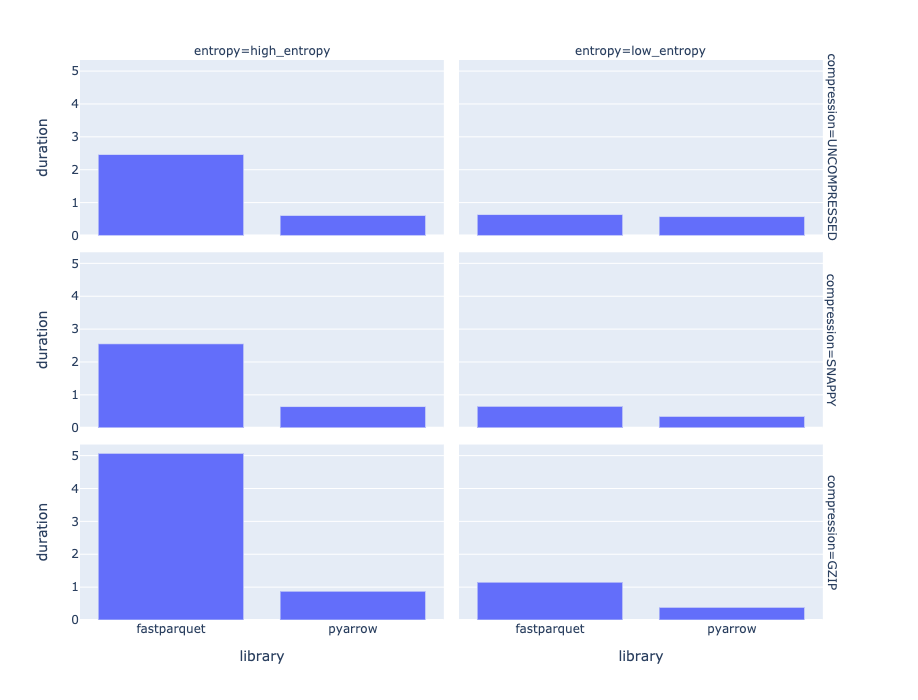

<IPython.core.display.Javascript object>

In [55]:
px.bar(read_df, x="library", y="duration", facet_row="compression", facet_col="entropy", height=700)

In [56]:
write_df = pd.DataFrame(
    write_results, columns=["entropy", "compression", "library", "duration"]
)

<IPython.core.display.Javascript object>

In [57]:
write_gzip_df = write_df[write_df.compression == "GZIP"]

<IPython.core.display.Javascript object>

In [58]:
write_not_gzip_df = write_df[write_df.compression != "GZIP"]

<IPython.core.display.Javascript object>

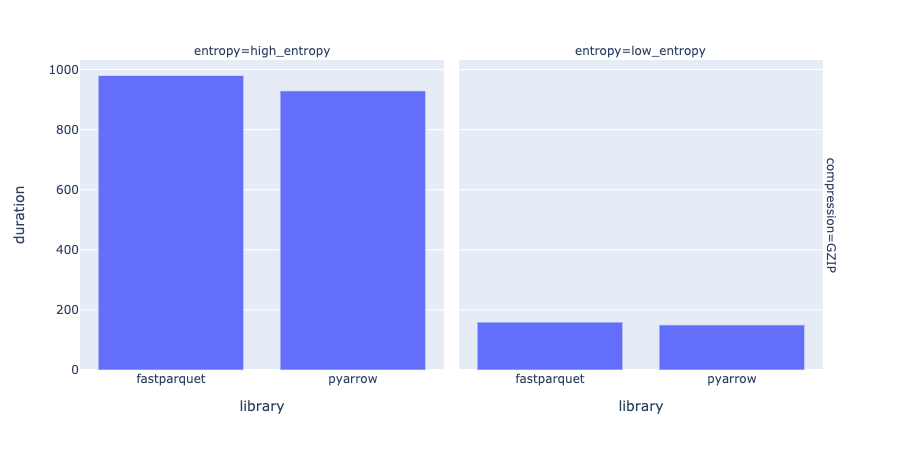

<IPython.core.display.Javascript object>

In [59]:
px.bar(
    write_gzip_df,
    x="library",
    y="duration",
    facet_row="compression",
    facet_col="entropy",
)

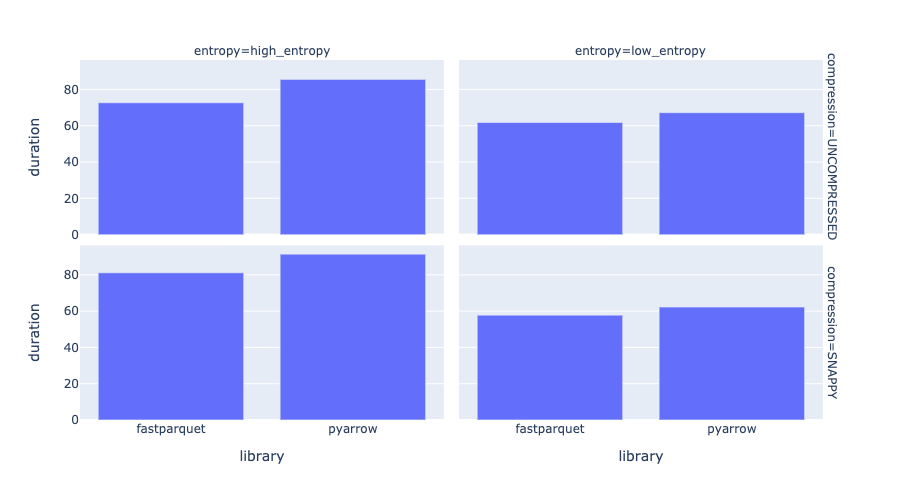

<IPython.core.display.Javascript object>

In [60]:
px.bar(
    write_not_gzip_df,
    x="library",
    y="duration",
    facet_row="compression",
    facet_col="entropy",
    height=500
)